# TASK #1

In [ ]:
import keras
import warnings
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product
from prettytable import PrettyTable
from sklearn.preprocessing import MinMaxScaler
from dateutil.relativedelta import relativedelta
from sklearn.metrics import r2_score, mean_absolute_percentage_error
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

1.	Find one real-world time-series from any open-source (not less than 150 time steps). For example, it can be some financial or economic indexes, weather measurements for several years, etc.



In [ ]:
df = pd.read_csv('Lluvia.csv', sep=';', index_col=['Date'], parse_dates=['Date'], dayfirst=True, encoding='cp1251')
df = df[['Specific_Humidity']]
df_LSTM = df.copy()

2.	Implement Multi-step LSTM prediction model and ARIMA prediction model for your time series, make the forecast (following the corresponding Jupyter Notebooks).

# LSTM

In [ ]:
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_lag = 48
n_seq = 48
n_test = 1
n_epochs = 100
n_batch = 1
n_neurons =  8

In [ ]:
# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    return scaler, train, test

def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(batch_input_shape=(n_batch, X.shape[1], X.shape[2])))
    model.add(keras.layers.LSTM(n_neurons, stateful=True))
    model.add(keras.layers.Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss = []
    history_val_loss = []
    for i in range(nb_epoch):
      print(f"Epoch {i+1}/{nb_epoch}")
      hist = model.fit(X, y, validation_split=0.1, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
      history_loss.append(hist.history['loss'])
      history_val_loss.append(hist.history['val_loss'])
      model.layers[0].reset_states()
    print(model.summary())
    return model, history_loss, history_val_loss

# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    X = X.reshape(1, 1, len(X))
    forecast = model.predict(X, batch_size=n_batch)
    return [x for x in forecast[0, :]]

# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        forecast = forecast_lstm(model, X, n_batch)
        forecasts.append(forecast)
    return forecasts

# обратная разность
def inverse_difference(last_ob, forecast):
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted

# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
        forecast = np.array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        inverted.append(inv_diff)
    return inverted

In [ ]:
scaler, train, test = prepare_data(df_LSTM, n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(df_LSTM, forecasts, scaler, n_test+2)

Epoch 1/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1744 - val_loss: 0.1166
Epoch 2/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1008 - val_loss: 0.0584
Epoch 3/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0568 - val_loss: 0.0404
Epoch 4/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0448 - val_loss: 0.0371
Epoch 5/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0420 - val_loss: 0.0364
Epoch 6/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0407 - val_loss: 0.0362
Epoch 7/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0397 - val_loss: 0.0360
Epoch 8/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0388 - val_loss: 0.0359
Epoch 9/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0380 - val_loss: 0.0357
Epoch 10/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0372 - val_loss: 0.0356
Epoch 11/100
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0366 - val_loss: 0.0354
Epoch 12/100
139/139 ━━━━━━━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (1, 8)                      │           1,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (1, 48)                     │             432 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,770 (26.45 KB)

 Trainable params: 2,256 (8.81 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,514 (17.64 KB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


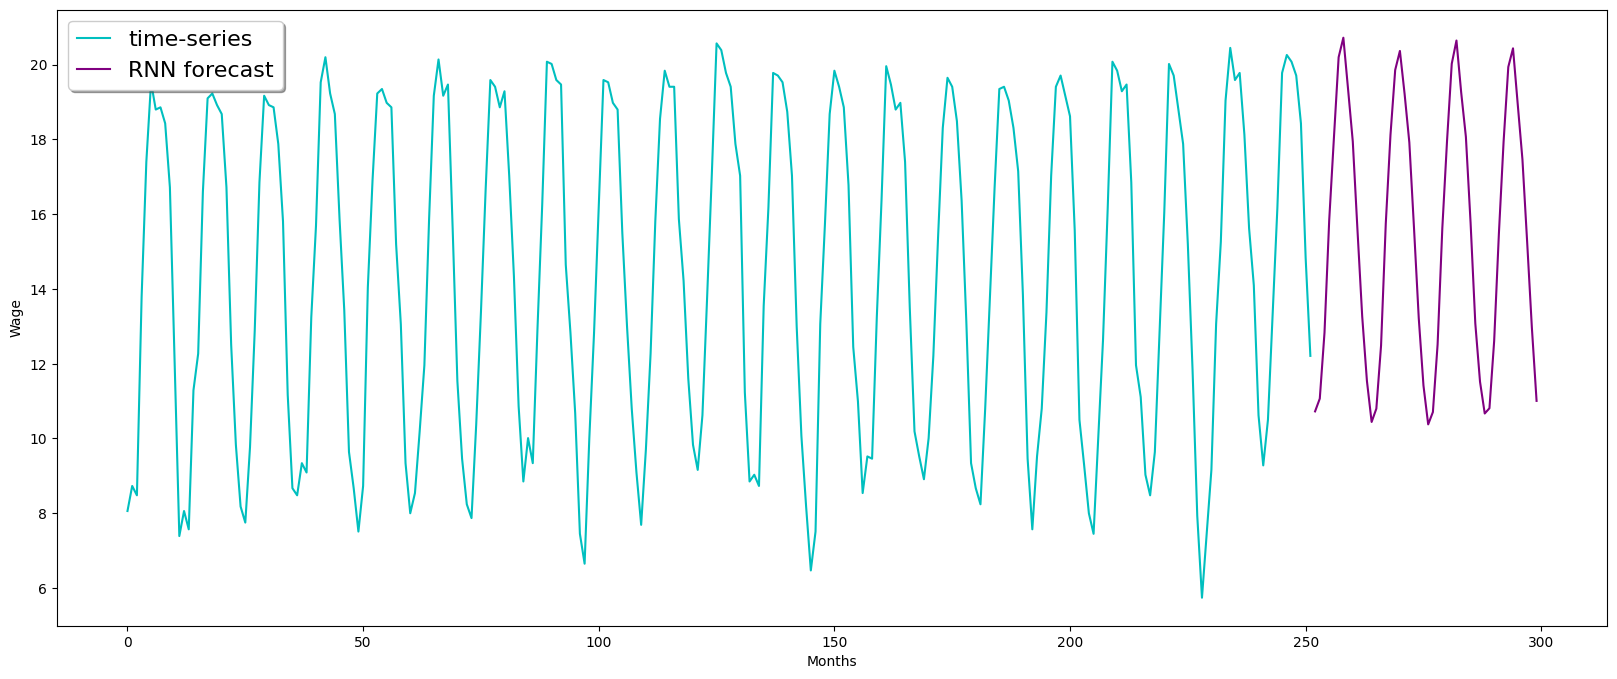

In [ ]:
# visualize

fig=plt.figure(figsize=(20,8))
plt.plot(df_LSTM.values[:], color='c')
off_s = len(df_LSTM) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [df_LSTM.values[off_s]] + forecasts[-1]
yaxis = [x-8 for x in yaxis[1:]]
plt.plot(xaxis[1:], yaxis, color='purple')

# print([x-1 for x in xaxis[1:]])
plt.ylabel('Wage')
plt.xlabel('Months')

plt.legend(('time-series', 'RNN forecast'),
           shadow=True, loc='upper left', handlelength=1.5, fontsize=16)
plt.show()

[0.024187684059143066] [0.031211573630571365]


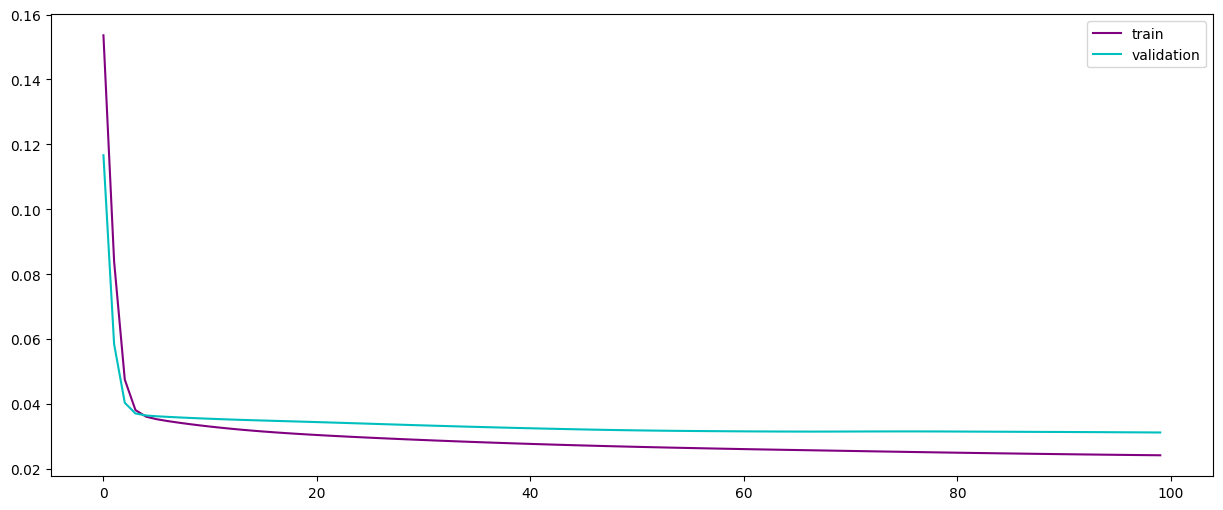

In [ ]:
# Loss functions for val and train sets
plt.figure(figsize=(15, 6))
plt.plot(history_loss, 'r',label='train', color='purple')
plt.plot(history_val_loss,label='validation', color='c')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

# ARIMA

In [ ]:
ps = range(0, 6)   # 5
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


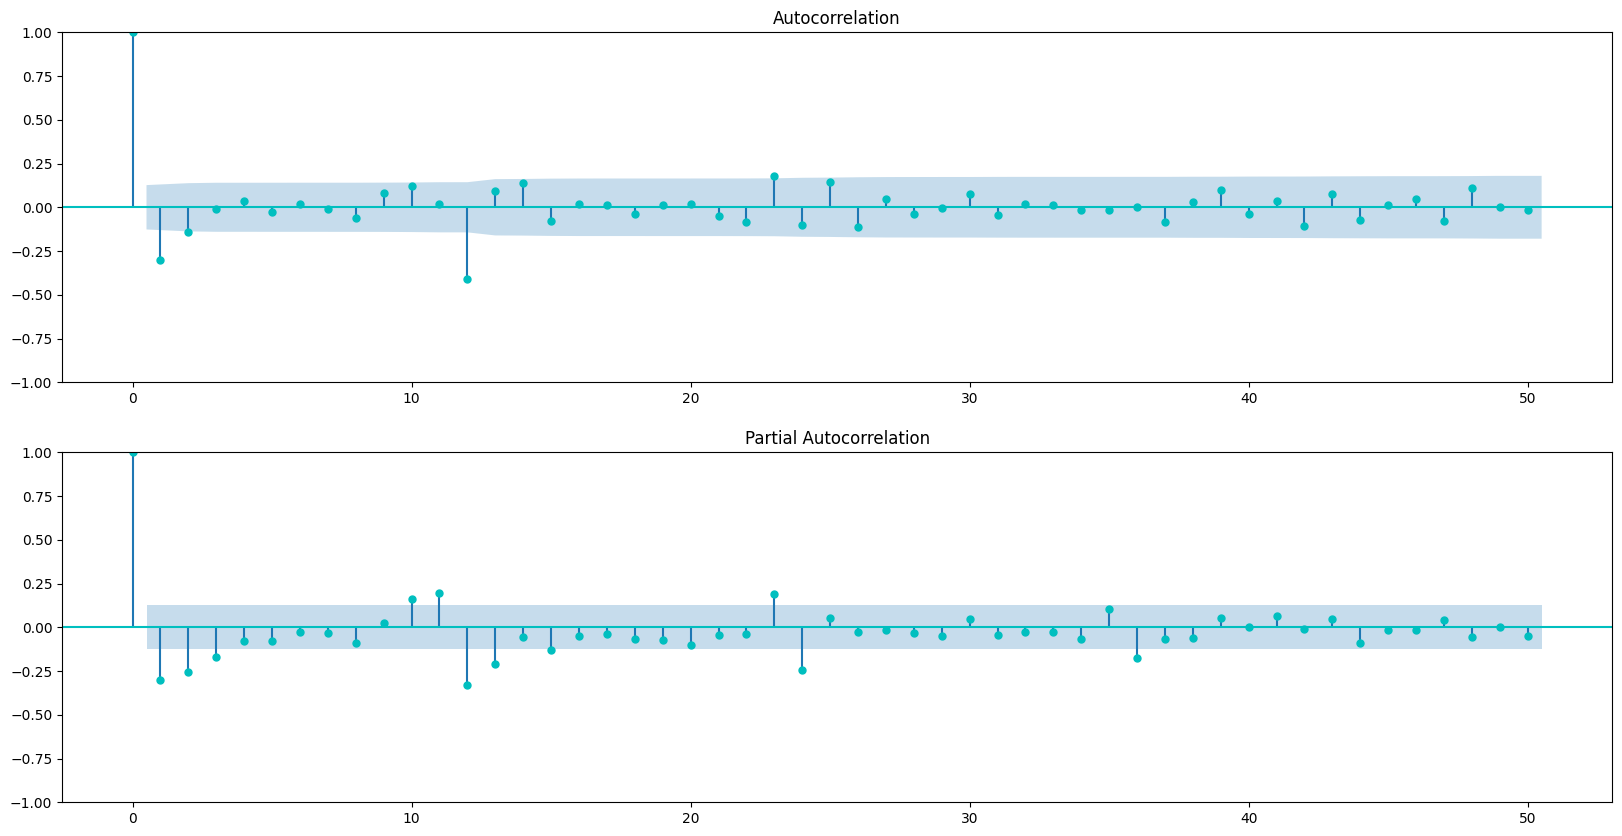

In [ ]:
sm.tsa.seasonal_decompose(df.Specific_Humidity)
sm.tsa.stattools.adfuller(df.Specific_Humidity)[1]
df['Specific_Humidity_box'], lmbda= stats.boxcox(df.Specific_Humidity)

sm.tsa.stattools.adfuller(df.Specific_Humidity_box)[1]

df['Specific_Humidity_box_diff'] = df.Specific_Humidity_box - df.Specific_Humidity_box.shift(12)
sm.tsa.seasonal_decompose(df.Specific_Humidity_box_diff[12:])
sm.tsa.stattools.adfuller(df.Specific_Humidity_box_diff[12:])[1]

df['Specific_Humidity_box_diff2'] = df.Specific_Humidity_box_diff - df.Specific_Humidity_box_diff.shift(1)
sm.tsa.seasonal_decompose(df.Specific_Humidity_box_diff2[13:])
sm.tsa.stattools.adfuller(df.Specific_Humidity_box_diff2[13:])[1]

plt.figure(figsize=(20,10))

# autocorrelation
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.Specific_Humidity_box_diff2[13:].values.squeeze(), lags=50, ax=ax, color='c')

# partial autocorrelation
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.Specific_Humidity_box_diff2[13:].values.squeeze(), lags=50, ax=ax, color='c')

plt.show()

In [ ]:
results = []
best_aic = float("inf")

for param in parameters_list:

    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(df.Specific_Humidity_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)

    #print wrong parameters and go on
    # AIC criteria:
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

     parameters         aic
6  (5, 3, 1, 0)  701.752411
5  (1, 2, 1, 0)  702.660399
4  (0, 5, 1, 0)  709.177469
3  (0, 2, 1, 0)  711.867659
2  (0, 1, 1, 0)  713.252327


In [ ]:
print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
print(best_model.summary())

Student test: p=0.691561
Dickey-Fuller test: p=0.0000000000000000000000000
                                      SARIMAX Results                                      
Dep. Variable:               Specific_Humidity_box   No. Observations:                  252
Model:             SARIMAX(5, 1, 3)x(1, 1, [], 12)   Log Likelihood                -340.876
Date:                             Sun, 20 Oct 2024   AIC                            701.752
Time:                                     02:42:38   BIC                            736.517
Sample:                                 01-01-2000   HQIC                           715.762
                                      - 12-01-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3849      0.06

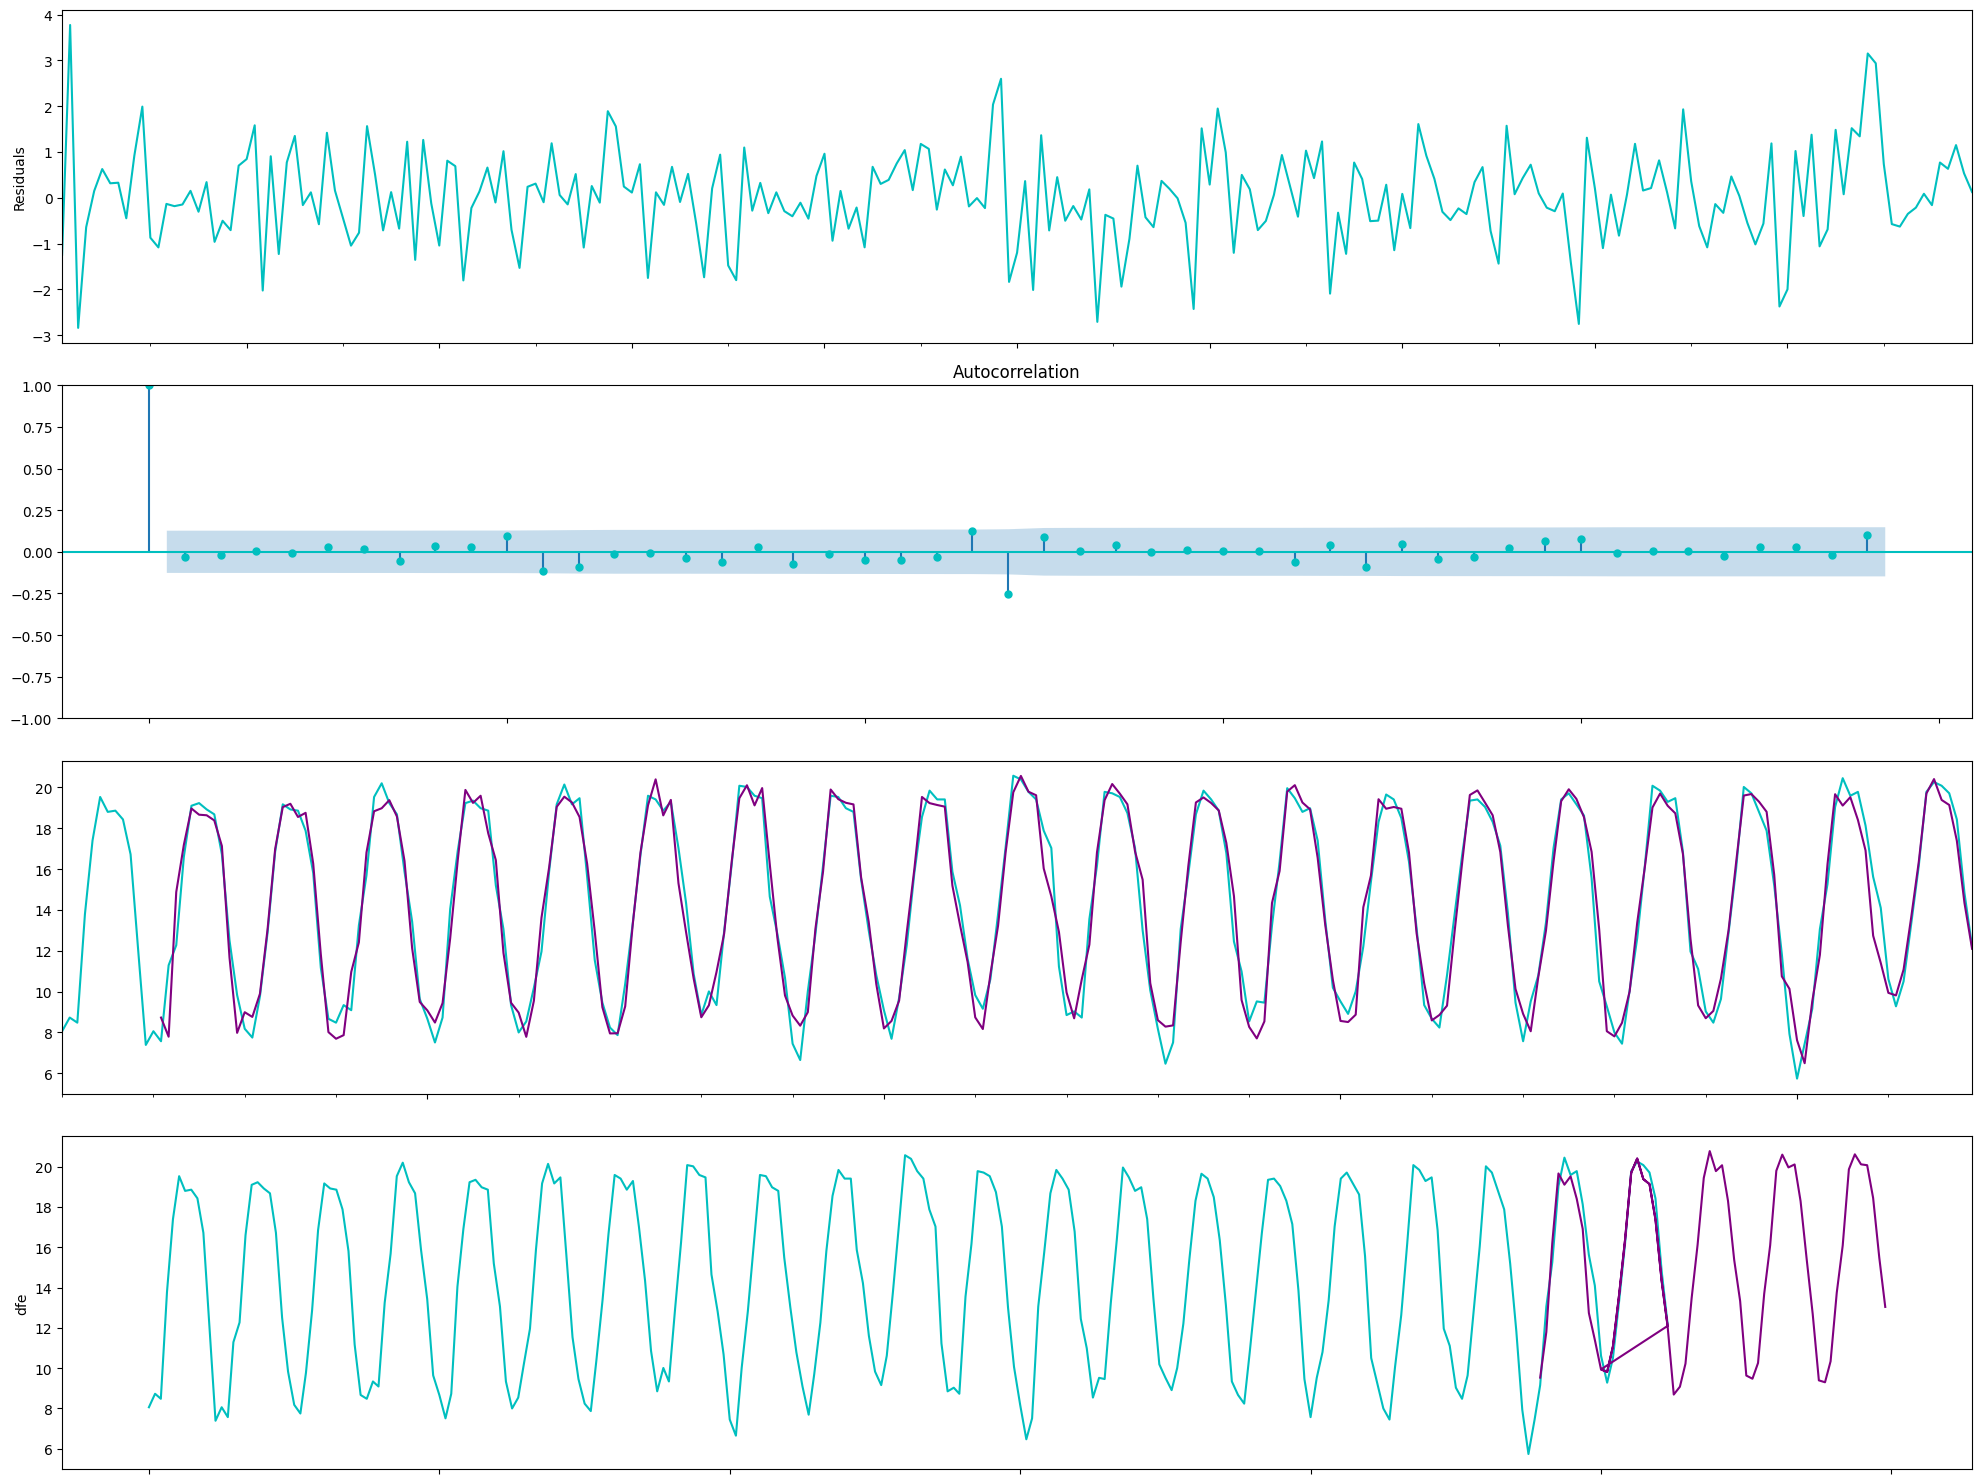

In [ ]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda * y + 1) / lmbda)

df['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(20, 15))

# Residuales
plt.subplot(411)
best_model.resid[13:].plot(color='c')
plt.ylabel('Residuals')
plt.gca().set_xticklabels([])
plt.gca().set_xlabel('')

# ACF de los residuales
ax = plt.subplot(412)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax, color='c')
ax.set_xticklabels([])
ax.set_xlabel('')

# Valores observados vs modelo
plt.subplot(413)
df.Specific_Humidity.plot(color='c')
df.model[13:].plot(color='purple')
plt.gca().set_xticklabels([])
plt.gca().set_xlabel('')

# Preparar datos futuros
df2 = df[['Specific_Humidity']]
date_list = [datetime.datetime.strptime("2020-01-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 48)]
future = pd.DataFrame(index=date_list, columns=df2.columns)
df2 = pd.concat([df2, future])

# Predecir valores futuros
df2['forecast'] = invboxcox(best_model.predict(start=230, end=290), lmbda)

# Graficar pronóstico
plt.subplot(414)
df2.Specific_Humidity.plot(color='c')
df2.forecast.plot(color='purple')
plt.ylabel('dfe')
plt.gca().set_xticklabels([])
plt.gca().set_xlabel('')

plt.tight_layout()
plt.show()

3.	Compare the forecasts of two models on the single plot and choose the most appropriate.

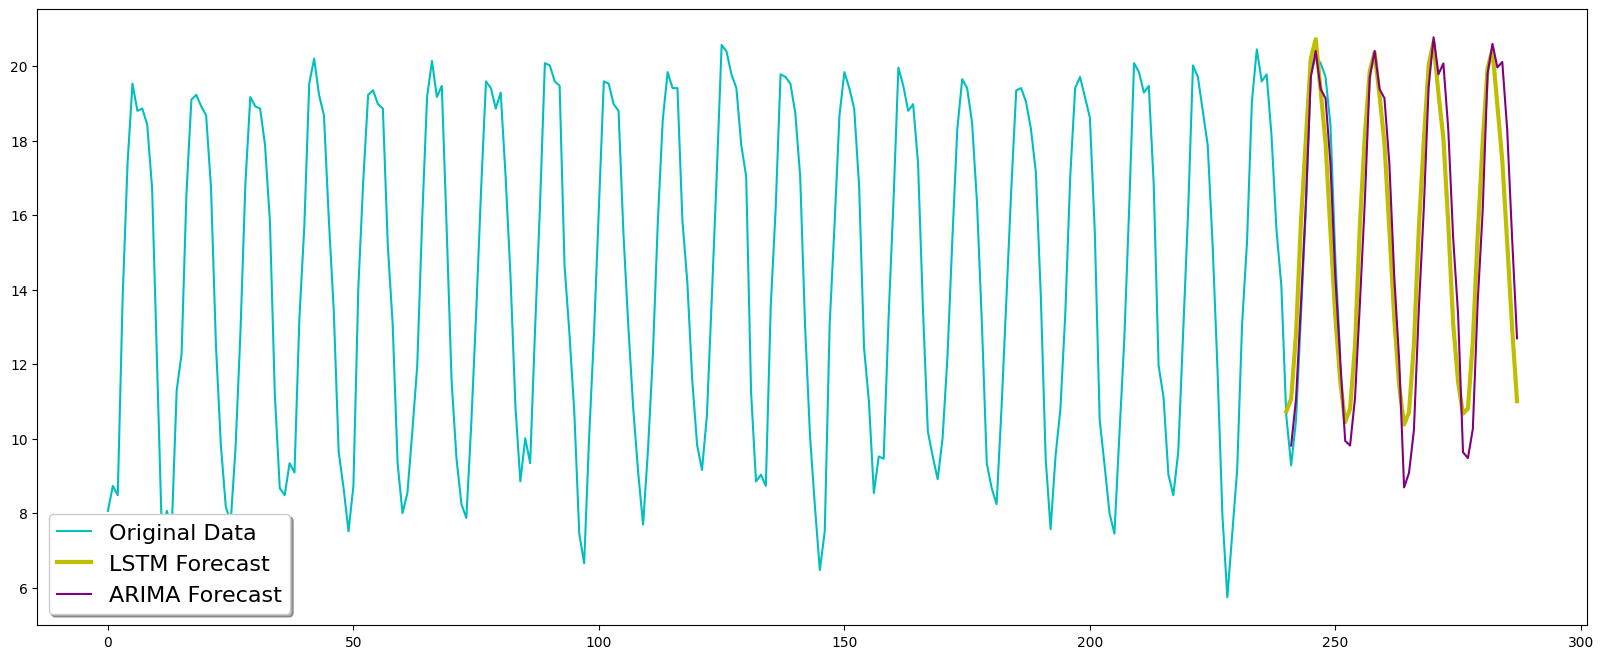

In [ ]:
fig=plt.figure(figsize=(20,8))

plt.plot(df_LSTM.values[:], color='c')
off_s = len(df_LSTM) - n_test +len(forecasts)  - 1
off_e = off_s + len(forecasts[0]) + 1
xaxis = [x for x in range(off_s, off_e)]
yaxis = [df_LSTM.values[off_s]] + forecasts[-1]
yaxis = [x-8 for x in yaxis[1:]]
plt.plot([x-12 for x in xaxis[1:]], yaxis, color='y', linewidth=3)

plt.plot([x-12 for x in xaxis[2:]], df2.forecast.tolist()[241:288], color='purple')


plt.legend(('Original Data', 'LSTM Forecast', 'ARIMA Forecast'),
           shadow=True, loc='lower left', handlelength=1.5, fontsize=16)

Based on this visual comparison, the ARIMA model (Purple) appears to be the more appropriate choice for this time series, as it closely tracks the original data, capturing both the trend and the periodic behavior more accurately than the LSTM model. The LSTM model (Green), while capturing the overall trend, shows some deviations in the amplitude of the oscillations.

4.	Evaluate MAPE and R2 metrics for your model

In [ ]:
result_tab = PrettyTable()
result_tab.field_names = ["Model", "r2", "MAPE"]
result_tab.add_row(["ARIMA", r2_score(df.Specific_Humidity.tolist()[192:241], df.model.tolist()[192:241]), mean_absolute_percentage_error(df.Specific_Humidity.tolist()[192:241], df.model.tolist()[192:241])])
result_tab.add_row(["LSTM", r2_score(yaxis[1:], df2.forecast.tolist()[241:288]), mean_absolute_percentage_error(yaxis[1:], df2.forecast.tolist()[241:288])])
print(result_tab)

+-------+--------------------+---------------------+
| Model |         r2         |         MAPE        |
+-------+--------------------+---------------------+
| ARIMA | 0.9411900311440936 | 0.07201518557909359 |
|  LSTM | 0.7983618309653803 | 0.09472097325153254 |
+-------+--------------------+---------------------+


Based on these two metrics, the ARIMA model clearly outperforms the LSTM model. ARIMA shows a better fit (higher $R^2$) and a lower percentage error (lower MAPE), indicating that it is more effective for modeling and predicting the time series in this case. In contrast, LSTM fails to capture the data patterns as well and performs worse compared to ARIMA.